프로젝트 : Segmentation map으로 도로 이미지 만들기
===

이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

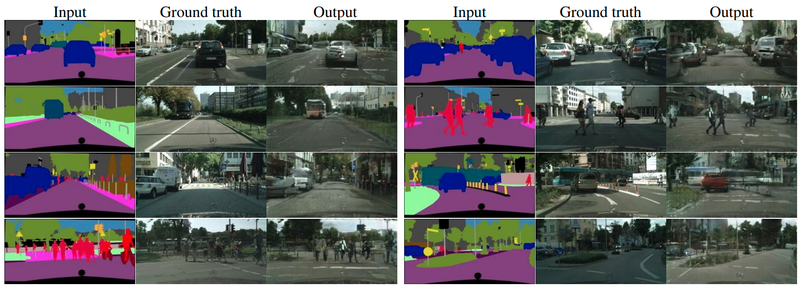   
    
이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다.     
데이터셋은 1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.    

아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 이번 데이터셋과 비슷한 레이블 정보 이미지를 사용하기 때문에 참고 하겠습니다.
- Tensorflow Pix2Pix Tutorial : https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko
    
-21.12.07-

# 1. 데이터 준비하기

In [2]:
import os

train_path = os.getenv('HOME')+'/aiffel/Exploration/E19/data/cityscapes/train/'
val_path = os.getenv('HOME')+'/aiffel/Exploration/E19/data/cityscapes/val/'
print("number of train data :", len(os.listdir(train_path)))
print("number of validation data :", len(os.listdir(val_path)))

number of train data : 1000
number of validation data : 5


- 1000개의 학습용 이미지 및 5개의 평가 이미지가 있음을 확인할 수 있습니다.
    
이번에는 아래 코드를 이용해 각각의 이미지들이 어떻게 생겼는지 확인해 봅시다. 학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.

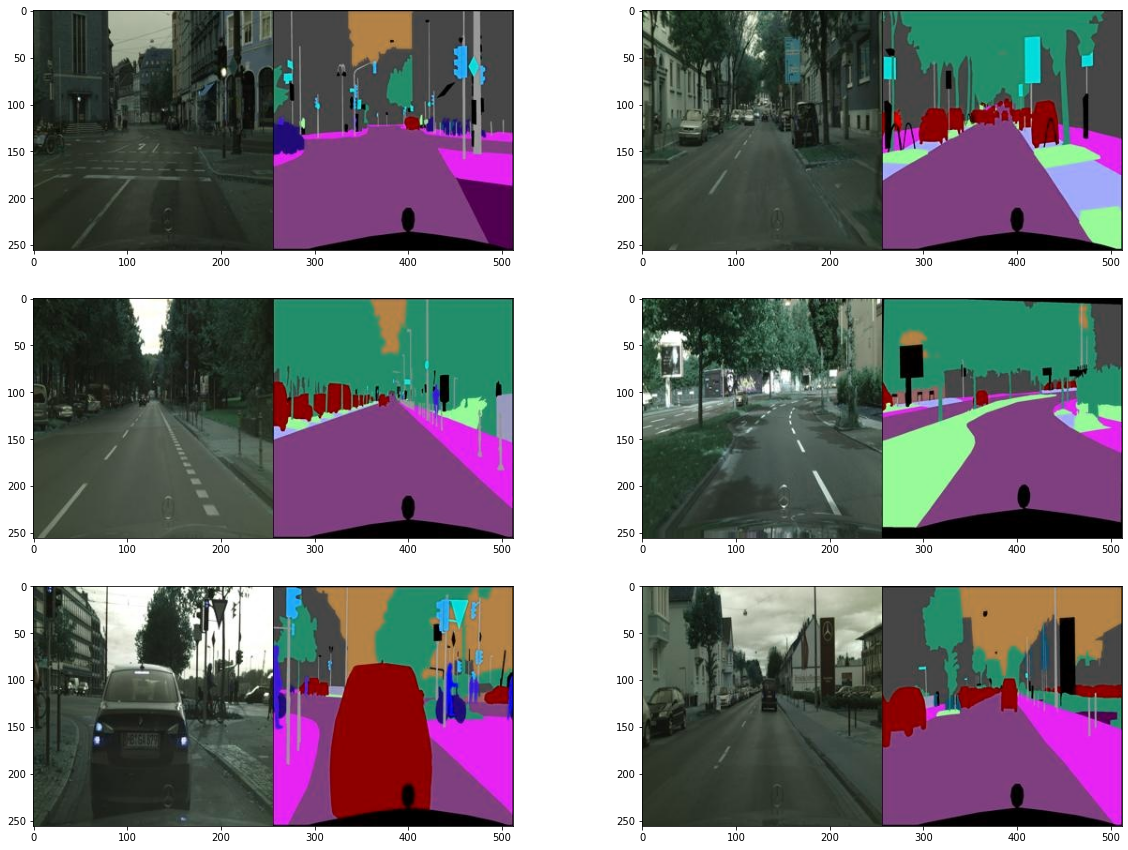

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 하나의 이미지에 스케치와 실제 이미지가 함께 포함되어 있음을 확인할 수 있습니다.     
    
이미지를 하나 열어 아래와 같이 크기를 확인해 보겠습니다.

In [4]:
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- (256, 512, 3)으로 확인되었습니다. 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용합니다.
   
아래 코드로 이미지를 나누어 봅시다.

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

In [6]:
# 이미지 하나 나눠보기 
f = train_path + os.listdir(train_path)[1]
sketch, colored = load_img(f)

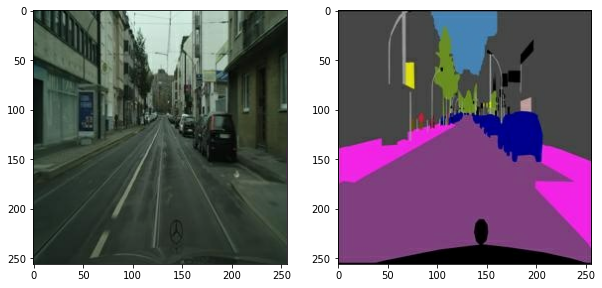

In [7]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

- 위와 같이 두 개 이미지로 나누었습니다. 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표입니다.    

앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 1000개뿐입니다. 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보겠습니다.

In [8]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) # 1
    
    _pad = tf.constant([[30,30],[30,30],[0,0]]) # 2 
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6]) # 3
    
    out = image.random_flip_left_right(out) # 4 
    out = image.random_flip_up_down(out) # 5
    
    if tf.random.uniform(()) < .5: # 6
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   # 채널기준 concat 한거 나누기 

- apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용합니다.    
    1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
    2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
    3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
    4. 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
    5. 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
    6. 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)    
    
위와 같이 구성한 함수를 데이터에 적용해 시각화 해봅시다.

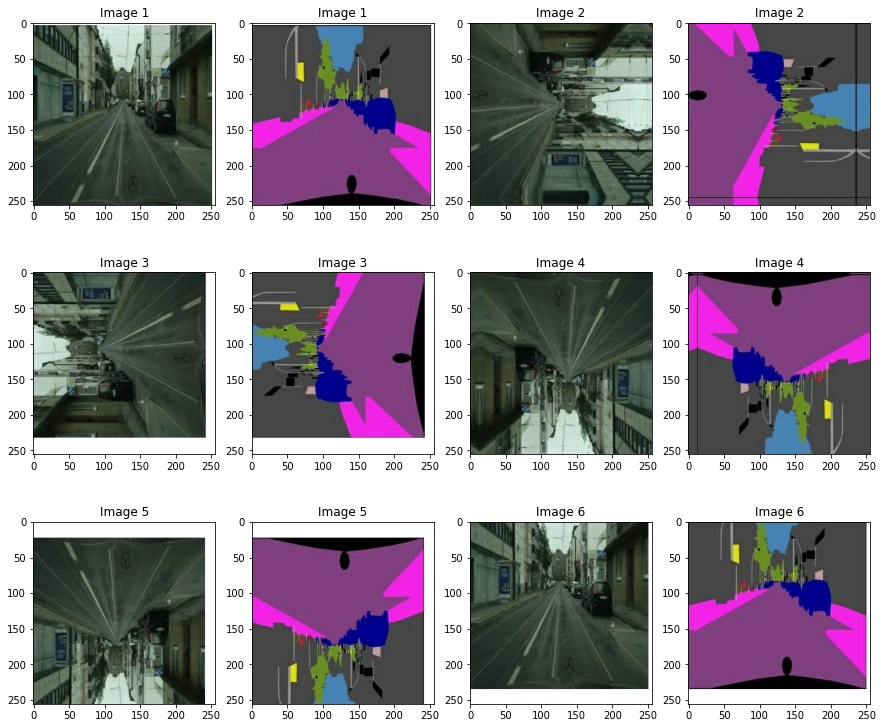

In [9]:
# 이미지 augmentation 예시 
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- 매우 다양한 이미지가 생성되는 것을 확인할 수 있습니다.     

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보겠습니다.

In [10]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

# train dataset 
train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

In [11]:
# test dataset
test_images = tf.data.Dataset.list_files(val_path + '*.jpg')
test_images = test_images.map(load_img).batch(4)

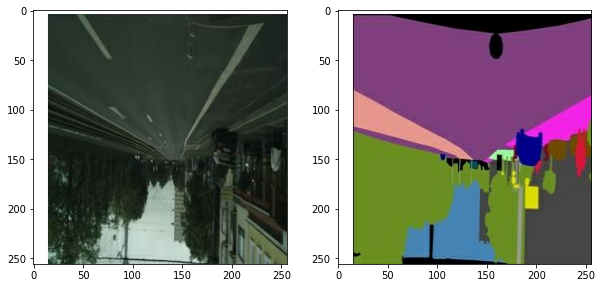

In [12]:
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 2. Generator 구성하기
    
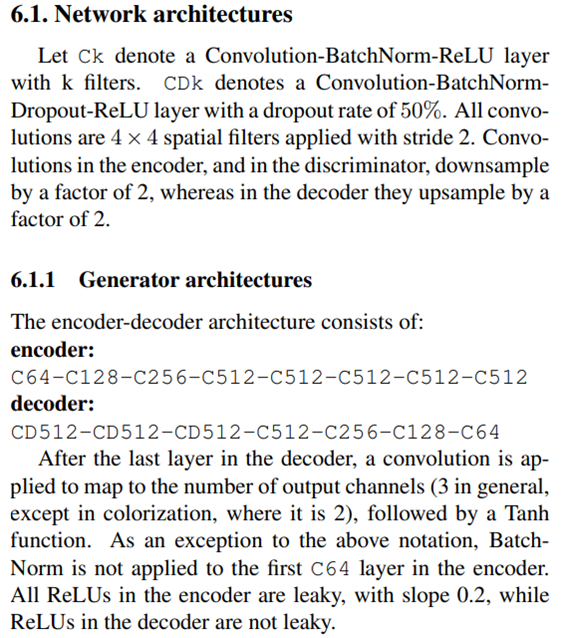
    

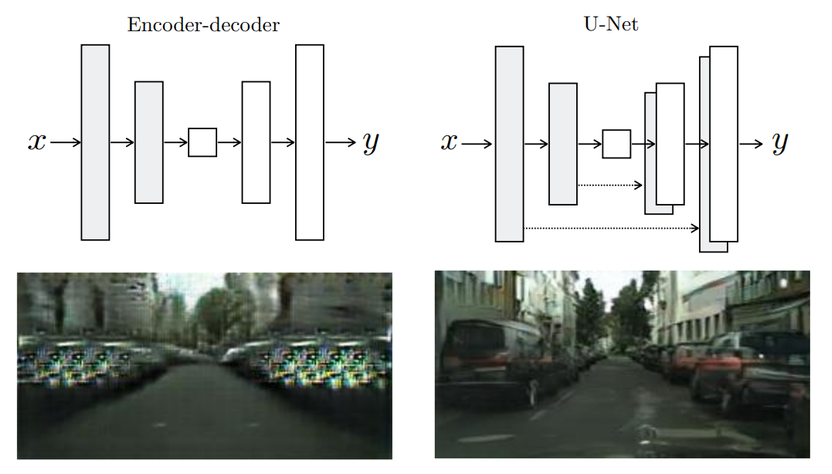
    
단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조의 Generator를 사용하겠습니다.     
    
먼저 Encoder 및 Decoder에 사용되는 기본적인 블록을 구현합니다. 


In [13]:
from tensorflow.keras import layers, Input, Model

# Encoder Block : Conv -> (Batchnorm) -> Leaky ReLU
    
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

- tf.random_normal_initializer(mean, stddev) : Initializer that generates tensors with a normal distribution    
    https://www.tensorflow.org/api_docs/python/tf/random_normal_initializer

In [14]:
inp = sketch[0] 
print(inp.shape)

(256, 256, 3)


In [15]:
# encode 확인 
down_model = downsample(3, 4) 
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [16]:
# Decoder Block : Transposed Conv -> Batchnorm -> (Dropout:처음 3개의 블록에 적용됨) -> ReLU

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [17]:
# decode 확인 
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


정의된 블록들을 이용해 한 번에 U-Net Generator를 정의해 봅니다. 

In [18]:
OUTPUT_CHANNELS = 3

def UNetGenerator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    
    # Encoder 
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]
    
    # Decoder
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

- Encoder와 Decoder 사이의 skip connection을 위해 skips 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았습니다.
- 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
    skips 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다.
- reversed(skips[:-1]) :    
    Encoder의 마지막 출력(skips[-1])은 Decoder로 직접 입력되므로 skip connection의 대상이 아니므로 제외하고,    
    Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이루기 때문에 skips리스트를 역순으로 변경해 줍니다. 

    
Generator 구현이 끝났습니다.

마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인해봅시다.

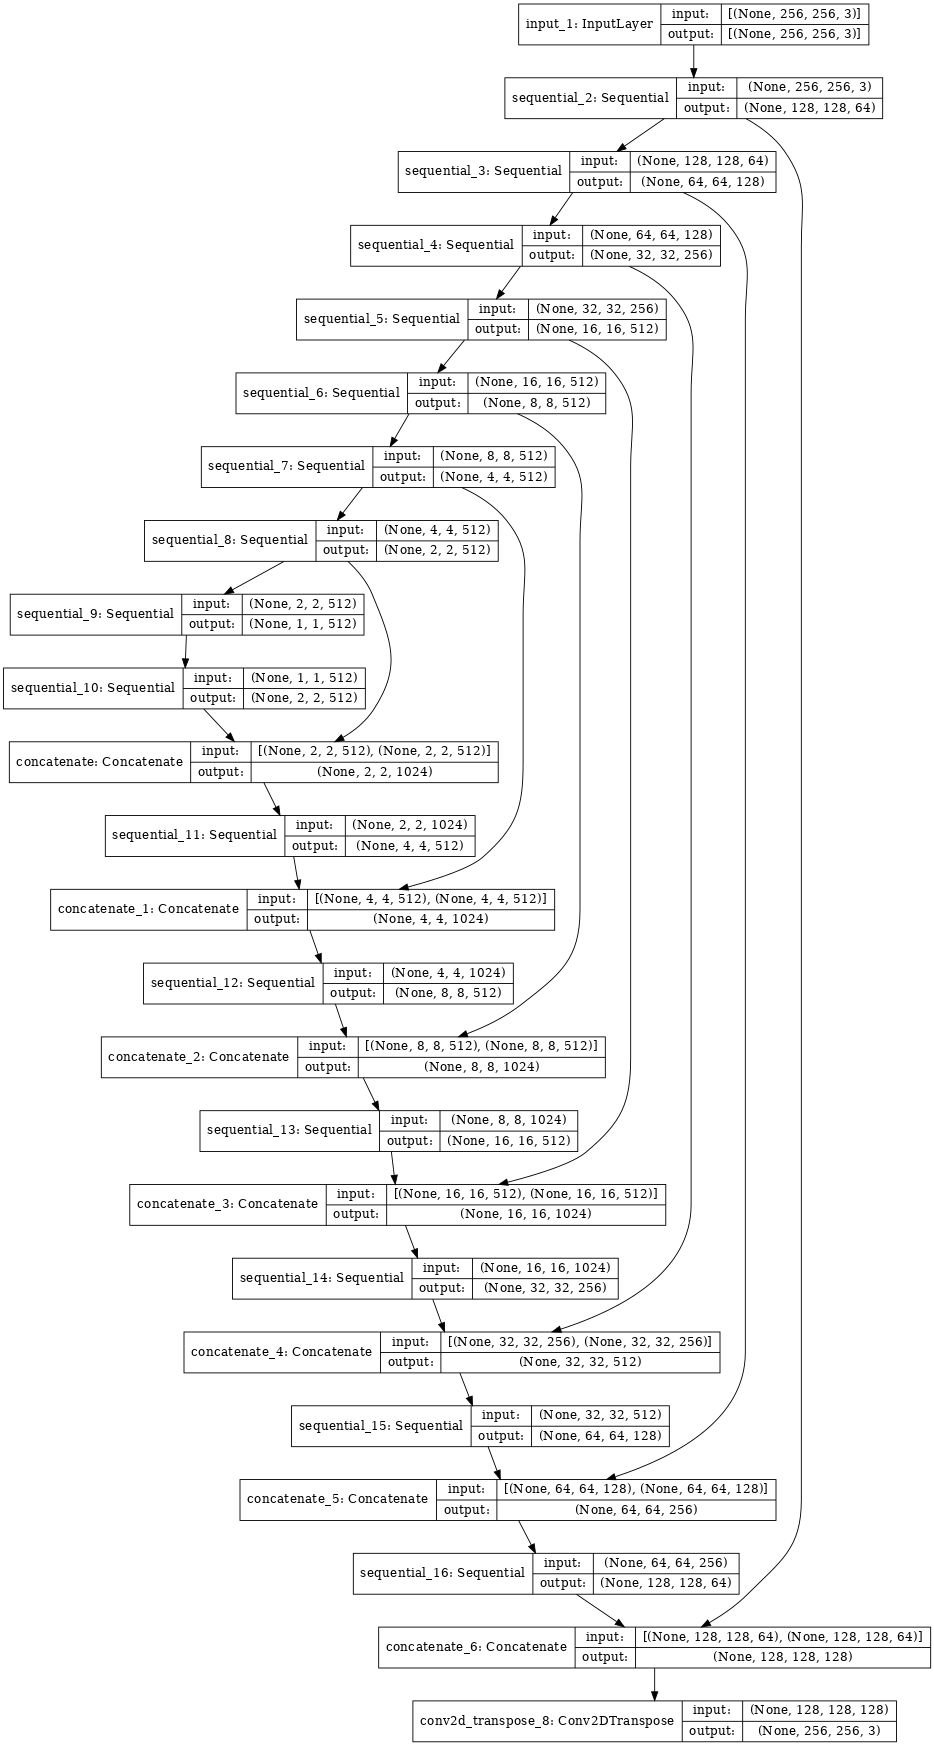

In [19]:
generator = UNetGenerator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

- tf.keras.utils.plot_model() : Converts a Keras model to dot format and save to a file   
    https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


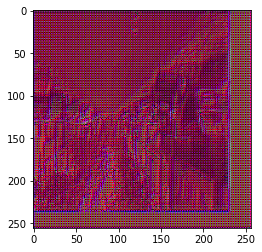

In [32]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

# 3. Discriminator 구성하기

Generator만으로 좋은 결과를 도출하기에는 부족합니다. 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요합니다.    
이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 봅니다.    

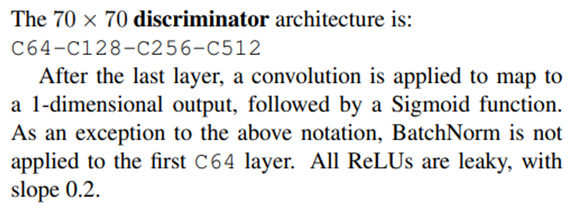    
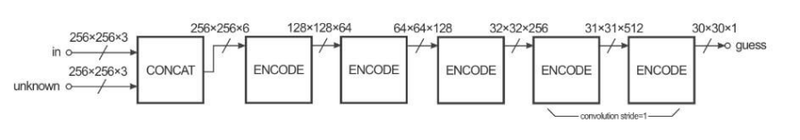    

- Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, ENCODE 라고 쓰인 5개의 블록을 통과합니다. 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었습니다.  
- 추가적으로 위 그림에서 최종 출력 크기가 (30,30,1)이 되어야 하는 이유는 70x70 PatchGAN을 사용했기 때문입니다.     
    최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정입니다.

In [21]:
# Discriminator : Conv -> BatchNorm -> Leaky ReLU

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

- 판별자는 2개의 입력을 받습니다.    
    1. 진짜로 분류해야 하는 입력 이미지 및 대상 이미지
    2. 가짜로 분류해야 하는 입력 이미지 및 생성된 이미지(생성기의 출력)     
    코드에서 이 두 입력을 함께 연결합니다(tf.concat([inp, tar], axis=-1))    
- 마지막 레이어 이후의 출력 형상은 (batch_size, 30, 30, 1)입니다.
- 출력의 각 30x30 패치는 입력 이미지의 70x70 부분을 분류합니다 (이러한 아키텍처를 PatchGAN이라고 함)
    - PatchGAN : https://sahiltinky94.medium.com/understanding-patchgan-9f3c8380c207

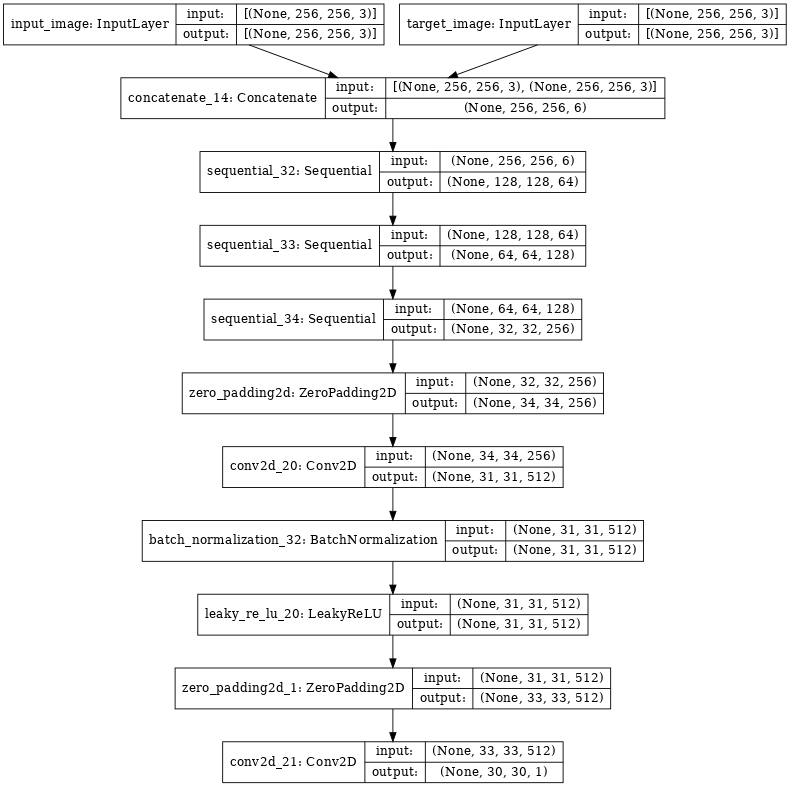

In [22]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

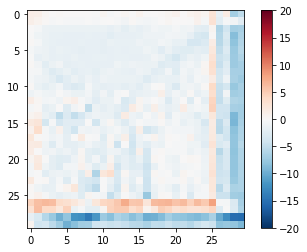

In [35]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

# 4. 학습 및 테스트하기

이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해 봅니다.

## 손실함수 정의 

먼저 학습에 필요한 손실함수부터 정의하겠습니다.
     
레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈습니다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해 봅니다.

In [23]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# generator loss = gan_loss + LAMBDA * l1_loss (여기서 LAMBDA = 100)
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

- 생성기 손실    
    생성된 이미지 및 tf.ones의 시그모이드 교차 엔트로피 손실입니다.    
    논문에는 생성 이미지와 대상 이미지 사이의 MAE(평균 절대 오차)인 L1 손실도 포함됩니다.   
    이를 통해 생성된 이미지가 대상 이미지와 구조적으로 유사해질 수 있습니다.

In [24]:
# discriminator loss = real_loss + generated_loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

- 판별자 손실     
    판별자 손실 함수는 진짜 이미지, 생성된 이미지의 두 입력을 받습니다.     
    real_loss는 진짜 이미지 및 tf.ones(진짜 이미지이기 때문)의 시그모이드 교차 엔트로피 손실입니다.     
    generated_loss는 생성된 이미지 및 tf.zeros(가짜 이미지이기 때문)의 시그모이드 교차 엔트로피 손실입니다.

## 옵티마이저 및 체크포인트-세이버 정의하기



In [27]:
from tensorflow.keras import optimizers

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

- tf.keras.optimizers.Adam(learning_rate, beta_1, beta_2=0.999) : Adam optimizer     
    https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/Exploration/E19/data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- tf.train.Checkpoint() : Manages saving/restoring trackable values to disk     
    https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint

## 이미지 생성하기

훈련 중에 일부 이미지를 플롯하는 함수를 작성합니다.
   
- 테스트 데이터세트의 이미지를 생성기로 전달합니다.
- 그러면 생성기가 입력 이미지를 출력으로 변환합니다.
- 마지막 단계로 예상을 플롯합니다.

In [42]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

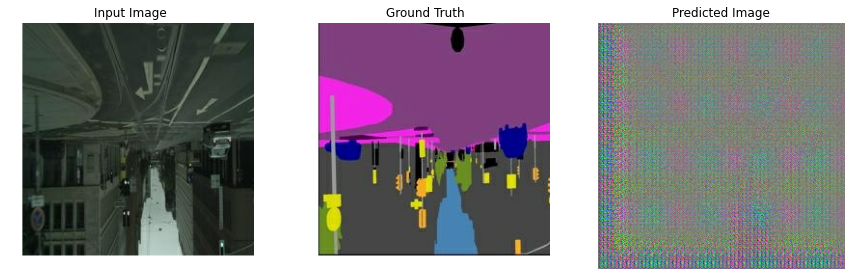

In [43]:
for example_input, example_target in train_images.take(1):
    generate_images(generator, example_input, example_target)

## 훈련하기

- 각 예에서 입력은 출력을 생성합니다.
- 판별자는 input_image 및 생성된 이미지를 첫 번째 입력으로 받습니다. 두 번째 입력은 input_image와 target_image입니다.
- 다음으로 생성기와 판별자 손실을 계산합니다.
- 그런 다음 생성기와 판별자 변수(입력) 모두에 대해 손실의 그래디언트를 계산하고 이를 옵티마이저에 적용합니다.
- 그런 다음 손실을 TensorBoard에 기록합니다.

In [29]:
EPOCHS = 300 # epoch 설정

import time
import datetime
from IPython import display

log_dir = os.getenv('HOME')+'/aiffel/Exploration/E19/data/logs/'

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

- tf.summary.create_file_writer() : Creates a summary file writer for the given log directory     
    https://www.tensorflow.org/api_docs/python/tf/summary/create_file_writer

In [46]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

- tf.summary.SummaryWriter.as_defalut() : Returns a context manager that enables summary writing     
    https://www.tensorflow.org/api_docs/python/tf/summary/SummaryWriter#as_default   
- tf.summary.scalar( name, data ) : Write a scalar summary    
    https://www.tensorflow.org/api_docs/python/tf/summary/scalar

In [47]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))
        
    checkpoint.save(file_prefix = checkpoint_prefix)

- IPython.display.clear_output() : Clear the output of the current cell receiving output     
    https://ipython.org/ipython-doc/3/api/generated/IPython.display.html#IPython.display.clear_output

- 실제 훈련 루프 :    
    epoch 수(300) 만큼 반복합니다.    
    각 epoch에서 표시 내용을 지우고 generate_images를 실행하여 진행 상황을 표시합니다.      
    각 epoch마다 훈련 데이터세트에 대해 반복하여 각 예에 대해 '.'를 인쇄합니다.    
    20개 epoch마다 체크포인트를 저장합니다.

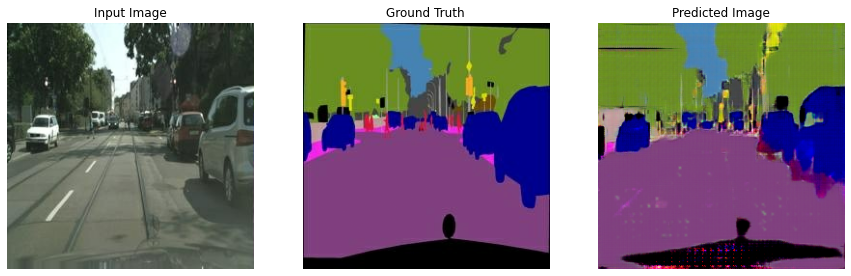

Epoch:  299
....................................................................................................
....................................................................................................
..................................................
Time taken for epoch 300 is 88.86804461479187 sec



In [55]:
fit(train_images, EPOCHS, test_images)

- 300 epoch 정도 돌리니 스케치와 비슷한 예측 이미지가 나온 것을 확인할 수 있다.  

# 회고

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.    
    데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
    
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.    
    U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.

3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.    
    300 epoch의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.